In [3]:
# Resources: https://pytorch.org/audio/stable/index.html
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

1.10.0+cu111
0.10.0+cu111


In [4]:
import os
import requests
import shutil

In [5]:
_SAMPLE_DIR = "_assets"

SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")
SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")
SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")
SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

os.makedirs(_SAMPLE_DIR, exist_ok=True)

def fetch_audio_file(url, path):
  with open(path, 'wb') as file_:
    file_.write(requests.get(url).content)

fetch_audio_file(SAMPLE_WAV_URL, SAMPLE_WAV_PATH)
fetch_audio_file(SAMPLE_MP3_URL, SAMPLE_MP3_PATH)
fetch_audio_file(SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH)
fetch_audio_file(SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH)

In [6]:
# Quering audio metadata from url
with requests.get(SAMPLE_WAV_URL, stream=True) as response:
  filedata = response.raw
  metadata = torchaudio.info(filedata, format="wav")
  print(f"Fetched {filedata.tell()} bytes.")

print(metadata)

Fetched 8192 bytes.
AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [7]:
# Quering audio metadata from file
metadata = torchaudio.info(SAMPLE_WAV_PATH)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [8]:
# Load audio file
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)
# By default, dtype=torch.float32 and range is normalized within [-1.0, 1.0]
waveform.shape, sample_rate

(torch.Size([1, 54400]), 16000)

In [9]:
# Play audio
from IPython.display import Audio, display
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

play_audio(waveform, sample_rate)

In [10]:
# Plot waveform and spectrogram
import matplotlib.pyplot as plt

def _plot(waveform, sample_rate, title):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    if title == "Waveform":
      axes[c].plot(time_axis, waveform[c], linewidth=1)
      axes[c].grid(True)
    else:
      axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
  figure.suptitle(title)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate):
  _plot(waveform, sample_rate, title="Waveform")

def plot_specgram(waveform, sample_rate):
  _plot(waveform, sample_rate, title="Spectrogram")

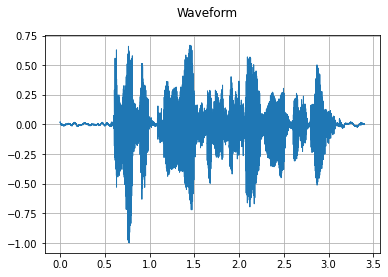

In [25]:
plot_waveform(waveform, sample_rate)

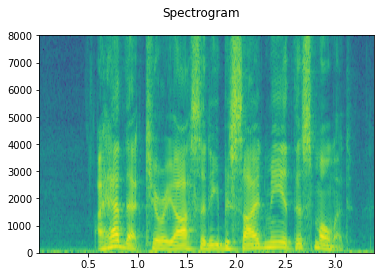

In [26]:
plot_specgram(waveform, sample_rate)

In [29]:
# Save audio
path = f"{_SAMPLE_DIR}/save_example_default.wav"
torchaudio.save(path, waveform, sample_rate, encoding="PCM_S", bits_per_sample=16, format="wav")

In [11]:
# Load again
metadata = torchaudio.info(path)
print(metadata)
waveform, sample_rate = torchaudio.load(path)
play_audio(waveform, sample_rate)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=32, encoding=PCM_F)


In [13]:
# RESAMPLING
# Resample an audio waveform from one frequency to another
import torchaudio.transforms as T
import torchaudio.functional as F

waveform, sample_rate = torchaudio.load(SAMPLE_WAV_PATH)

resample_rate = 32000

resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform1 = resampler(waveform)

resampled_waveform2 = F.resample(waveform, sample_rate, resample_rate)

play_audio(waveform, sample_rate)
play_audio(resampled_waveform1, resample_rate)
play_audio(resampled_waveform2, resample_rate)

# parameter
# Lowpass filter width
# Larger lowpass_filter_width -> sharper, more precise filter, but more computationally expensive.
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=12)

# Rolloff
# Lower rolloff reduces the amount of aliasing, but it will also reduce some of the higher frequencies.
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.80)

# Window function
# default = Hann window filter
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="kaiser_window")

In [ ]:
# AUDIO DATA AUGMENTATION
# - Applying effects and filtering
# - Adding background noise
# - Applying codec to Tensor object

In [33]:
torchaudio.sox_effects.effect_names()

['allpass',
 'band',
 'bandpass',
 'bandreject',
 'bass',
 'bend',
 'biquad',
 'chorus',
 'channels',
 'compand',
 'contrast',
 'dcshift',
 'deemph',
 'delay',
 'dither',
 'divide',
 'downsample',
 'earwax',
 'echo',
 'echos',
 'equalizer',
 'fade',
 'fir',
 'firfit',
 'flanger',
 'gain',
 'highpass',
 'hilbert',
 'loudness',
 'lowpass',
 'mcompand',
 'norm',
 'oops',
 'overdrive',
 'pad',
 'phaser',
 'pitch',
 'rate',
 'remix',
 'repeat',
 'reverb',
 'reverse',
 'riaa',
 'silence',
 'sinc',
 'speed',
 'stat',
 'stats',
 'stretch',
 'swap',
 'synth',
 'tempo',
 'treble',
 'tremolo',
 'trim',
 'upsample',
 'vad',
 'vol']

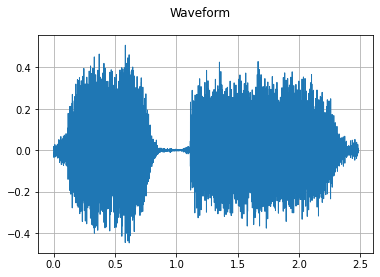

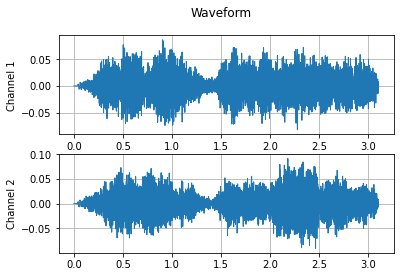

In [14]:
# Apply effects to file
def get_sample(path, resample=16000):
  effects = [
    ["remix", "1"],
    ["lowpass", f"{resample // 2}"],
    ["rate", f'{resample}'],
    ]
  waveform, sample_rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
  return waveform, sample_rate  

waveform1, sample_rate1 = get_sample(SAMPLE_WAV_PATH, resample=16000)
plot_waveform(waveform1, sample_rate1)
print()

# Apply effects to tensor
effects = [
  ["lowpass", "-1", "300"], # apply single-pole lowpass filter
  ["speed", "0.8"],  # reduce the speed
                     # This only changes sample rate, so it is necessary to
                     # add `rate` effect with original sample rate after this.
  ["rate", f"{sample_rate1}"],
  ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(waveform1, sample_rate1, effects)
plot_waveform(waveform2, sample_rate2)

In [15]:
play_audio(waveform1, sample_rate1)
play_audio(waveform2, sample_rate2)

Noise:



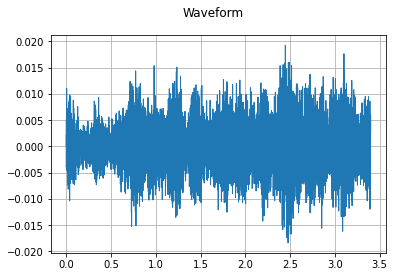

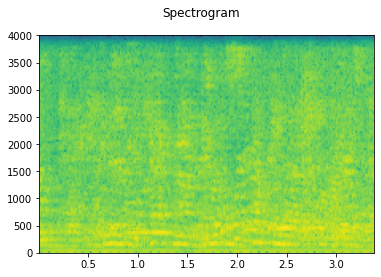

SNR: 20 [dB]



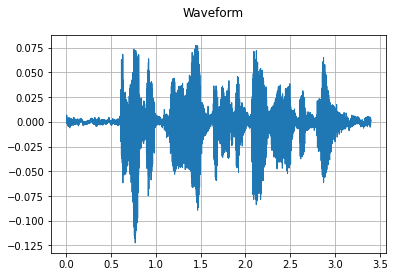

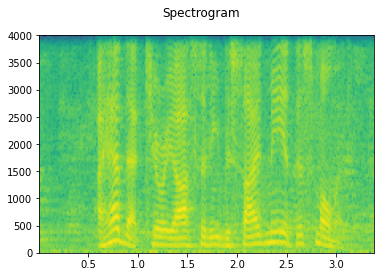

SNR: 10 [dB]



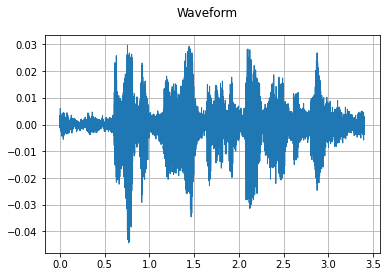

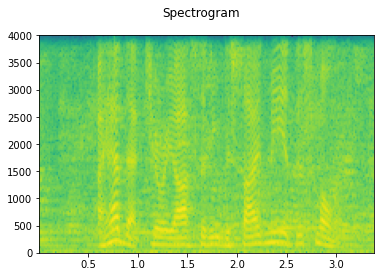

SNR: 3 [dB]



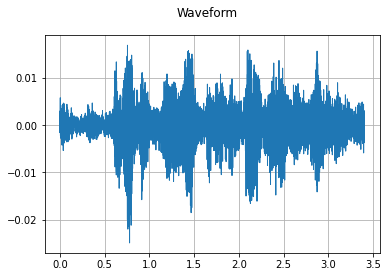

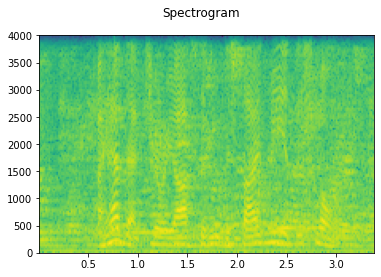

In [16]:
# Add background noise -> manually scale/add tensors
import math
sample_rate = 8000
speech, _ = get_sample(SAMPLE_WAV_SPEECH_PATH, resample=sample_rate)
noise, _ = get_sample(SAMPLE_NOISE_PATH, resample=sample_rate)
noise = noise[:, :speech.shape[1]]

print('Noise:\n')
plot_waveform(noise, sample_rate)
plot_specgram(noise, sample_rate)
play_audio(noise, sample_rate)

speech_power = speech.norm(p=2)
noise_power = noise.norm(p=2)

for snr_db in [20, 10, 3]:
  snr = math.exp(snr_db / 10)
  scale = snr * noise_power / speech_power
  noisy_speech = (scale * speech + noise) / 2
  print(f'SNR: {snr_db} [dB]\n')
  plot_waveform(noisy_speech, sample_rate)
  plot_specgram(noisy_speech, sample_rate)
  play_audio(noisy_speech, sample_rate)

In [17]:
# Apply codec
waveform, sample_rate = get_sample(SAMPLE_WAV_SPEECH_PATH, resample=8000)

configs = [
    {"format": "wav", "encoding": 'ULAW', "bits_per_sample": 8},
    {"format": "gsm"},
    {"format": "mp3", "compression": -9},
    {"format": "vorbis", "compression": -1}
]

for param in configs:
  print(param)
  augmented = F.apply_codec(waveform, sample_rate, **param)
  play_audio(augmented, sample_rate)

{'format': 'wav', 'encoding': 'ULAW', 'bits_per_sample': 8}


{'format': 'gsm'}


{'format': 'mp3', 'compression': -9}


{'format': 'vorbis', 'compression': -1}


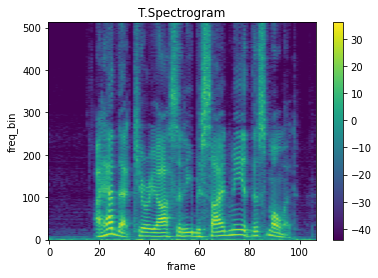

In [39]:
# AUDIO FEATURE EXTRACTIONS
# Spectrogram: To get the frequency make-up of an audio signal as it varies with time, you can use Spectrogram.

waveform, sample_rate = get_sample(SAMPLE_WAV_SPEECH_PATH, resample=16000)

n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(waveform)

import librosa
# librosa is a python package for music and audio analysis.
def plot_spectrogram(spec):
  fig, axs = plt.subplots(1, 1)
  axs.set_title('T.Spectrogram')
  axs.set_ylabel('freq_bin')
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect='auto')
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


plot_spectrogram(spec[0])

In [21]:
# DATASETS
YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)

dataset = torchaudio.datasets.YESNO(YESNO_DATASET_PATH, download=True)

waveform, sample_rate, label = dataset[0]
play_audio(waveform, sample_rate)